# GAMALOS (GAlaxies MAking LOve Simulation)

## Theoric remarks

Report: write a short report containing:
- a short introduction to the N-body problem, the difference between
collisional and collisionless systems and the force estimate in
collisionless simulations based on tree algorithms. Short general
description of the fireworks package and its implementation.
- Description of the methods (integrators, force estimator) used.
- Description of the initial conditions and simulation setup.
- Results and discussion. They depends on the specific project you
chose, but I expect at least one plot showing the main conclusion of
your analysis.

<div class='alert alert-danger' role='alert'>
Inserisci info teoriche
</div>

## Computation

In [1]:
#first of all, we import all the packages for Particles, integrators, ic...

import numpy as np
import pandas as pd
from fireworks.ic import ic_two_body
import matplotlib.pyplot as plt
from fireworks.nbodylib.integrators import integrator_leapfrog_galaxy, integrator_leapfrog, integrator_leapfrog_galaxy_encounter, integrator_tsunami
from fireworks.nbodylib.dynamics import acceleration_pyfalcon
from fireworks.nbodylib.timesteps import adaptive_timestep_r
from fireworks.particles import Particles
from typing import Optional, Tuple, Callable, Union
import time

#from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

We can import the data of one galaxy at first. The units are still Nbody units.

In [2]:
df_0 = pd.read_csv("data_cvs/Nbody_disc.csv")

# slice dataframe
num_particles = 1e3
df = df_0.iloc[:int(num_particles)]

df.head(10)

,mass,x,y,z,vx,vy,vz
0,1.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,1.000000e-11,-3.419583,-1.901788,0.0,0.118878,-0.213752,0.0
2,1.000000e-11,-14.046839,-2.403541,0.0,0.040952,-0.239330,0.0
3,1.000000e-11,-4.618003,6.269821,0.0,-0.222721,-0.164044,0.0
4,1.000000e-11,-6.045516,0.257974,0.0,-0.011730,-0.274897,0.0
5,1.000000e-11,-1.393104,1.578234,0.0,-0.124900,-0.110249,0.0
6,1.000000e-11,-1.150877,-1.762433,0.0,0.139480,-0.091081,0.0
7,1.000000e-11,0.593887,-1.003781,0.0,0.086283,0.051049,0.0
8,1.000000e-11,2.423492,-10.266498,0.0,0.257402,0.060762,0.0
9,1.000000e-11,-3.279328,5.118040,0.0,-0.231783,-0.148512,0.0


### 1. Initial conditions
We generated a Particles instance for each galaxy

In [3]:
# create a class with the mass, pos, vel of each element of the Galaxy

masses = df[['mass']]
positions = df[['x', 'y', 'z']]
velocities = df[['vx', 'vy', 'vz']]

# reshape mass array as 1D array
masses = masses.values.reshape(-1)

Galaxy1 = Particles(positions.values, velocities.values, masses)
print(Galaxy1.pos.shape)

(1000, 3)


In [4]:
# do the same for the other galaxy
# this second galaxy is the same as the first one, but translated by a certain value

pos_translation = np.array((40., 20., 0.))
vel_translation = np.array((-0.2, 0., 0.))

# apply this translation to find the second galaxy

positions_gal_2 = positions.values + pos_translation
velocities_gal_2 = velocities.values + vel_translation
Galaxy2 = Particles(positions_gal_2, velocities_gal_2, masses)

### Rotation curve and Surface density profile
Let's plot the rotation curve and the surface density profile for one galaxy, in particular for Galaxy 1. 

The **rotation curve** of a galaxy shows the azimuthal velocity as function of the cylindrical radius . To estimate the azimuthal velocity for each particle we transform the Cartesian coordinates to cylindrical: 

$$
\begin{cases}
R_{\text{cyl}} = \sqrt(x^2+y^2) \\
\phi = \arctan(\frac{y}{x}) \\
z=z
\end{cases}
$$

We then computed the azymuthal velocity for all the particles using: 
$$
V_\phi = V_y \cdot \cos(\phi) - V_x\cdot \sin(\phi)
$$

We then plotted $V_\phi$ vs $R$ to obtain the rotation curve of the galaxy. 

The **surface density profile** $\Sigma$ shows the amount of mass in a cylindrical ring divided by the area of the ring. To estimate it we bin the particles on the cylindrical radius $R_{\text{cyl}}$, then we sum all the masses of the particles to obtain $M_{\text{tot, ring}}$ and then the area of the ring is given by $\pi (R^2_{\text{outer}}-R^2_{\text{inner}})$ where $R_{\text{inner}}$ and $R_{\text{outer}}$ are the borders of the considered bin. Finally $\Sigma_{\text{ring}}=M_{\text{tot, ring}}/A_{\text{ring}}$. 

We plotted the initial number suface density of the disc, which means that we use the number of particles instead of the total mass of the ring, as function of the cylindrical radius. 

In [5]:
def rotation_curve_rescaled(galaxy: Particles):
    
    # rescale the position and velocity of the particles
    dx = galaxy.pos[:,0] - galaxy.pos[0,0]
    dy = galaxy.pos[:,1] - galaxy.pos[0,1]
    dz = galaxy.pos[:,2] - galaxy.pos[0,2]

    dvx = galaxy.vel[:,0] - galaxy.vel[0,0]
    dvy = galaxy.vel[:,1] - galaxy.vel[0,1]
    dvz = galaxy.vel[:,2] - galaxy.vel[0,2]

    # compute the cylindrical radius and azimuthal angle
    Rcyl = np.sqrt(dx**2 + dy**2)                   # cylindrical radius
    phi = np.arctan2(dy, dx)                        # azimuthal angle
    z = dz                                          # z-coordinate

    # compute azimuthal velocity    
    vel_phi = dvy * np.cos(phi) - dvx * np.sin(phi)     # azimuthal velocity

    return Rcyl, dz, vel_phi

def surface_density(Rcyl):
    H, edge = np.histogram(Rcyl, bins=20)                                          # histogram of the cylindrical radius
    area =  np.pi * (edge[1:]**2 - edge[0:-1]**2)                                  # area of every bin (every concentric ring) 
    mid = 0.5 * (edge[1:] + edge[0:-1])                                            # midpoint of every bin  

    return mid, H, area

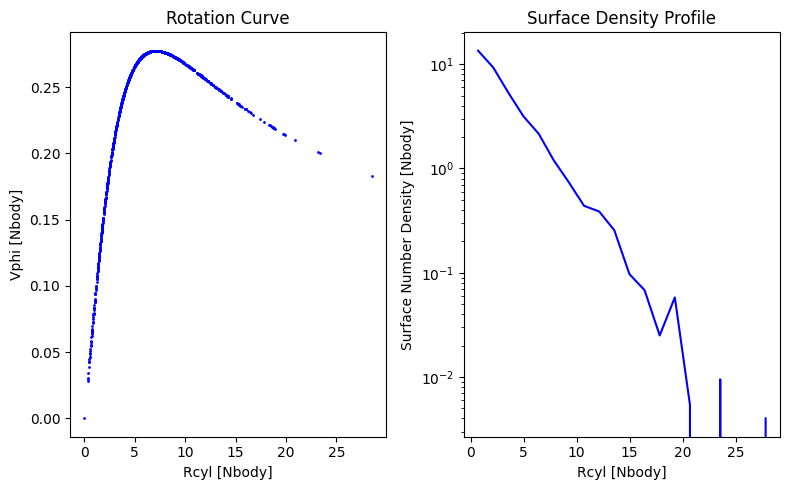

In [7]:
# compute rotation curve and surface density
Rcyl, _, vel_phi = rotation_curve_rescaled(Galaxy1)
mid, H, area = surface_density(Rcyl)

# rotation curve plot
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.plot(Rcyl, vel_phi, 'o', markersize=1, c='b')
plt.xlabel("Rcyl [Nbody]")
plt.ylabel("Vphi [Nbody]")
plt.title("Rotation Curve")

# surface density plot
plt.subplot(1, 2, 2)
plt.yscale('log')
plt.plot(mid, H / area, c='b')
plt.xlabel("Rcyl [Nbody]")
plt.ylabel("Surface Number Density [Nbody]")
plt.title("Surface Density Profile")

plt.tight_layout()
plt.show()  


### Orbital integration of Galaxy 1
Let's try an orbital simulation of the first galaxy to see if the integration works (in this test we used the leap-frog method).

Define helper function for the integration using `integrator_leapfrog_galaxy` and the method `Etot_vett` inside the Particles class.

In [8]:
def integration_leapfrog(galaxy: Particles, h: float, tsimulation: float, t: float, soft: float):
    N = len(galaxy.mass)         # number of particles in the galaxy
    path = [galaxy.pos]          # list to store the position of the galaxy
    velocity = [galaxy.vel]      # list to store the velocity of the galaxy
    time = []
    timestep = []
    
    Etot_leapfrog = []
    Ekin_leapfrog = []
    Epot_leapfrog = []

    R_cyl, _, vel_phi = rotation_curve_rescaled(galaxy)
    R_cyl = [R_cyl]
    V_phi = [vel_phi]

    while t < tsimulation:
        result = integrator_leapfrog(particles=galaxy, tstep=h, acceleration_estimator=acceleration_pyfalcon, softening=soft)
        updated_galaxy, _,  updated_acc, _, _ = result
        #updated_galaxy.pos -= updated_galaxy.pos[0]
        #updated_galaxy.vel -= updated_galaxy.vel[0]
        path.append(updated_galaxy.pos)
        velocity.append(updated_galaxy.vel)
            
        Etot_n, Ekin_n, Epot_n = updated_galaxy.Etot_vett()
        Etot_leapfrog.append(Etot_n)
        Ekin_leapfrog.append(Ekin_n)
        Epot_leapfrog.append(Epot_n)
    
        R, z, V = rotation_curve_rescaled(updated_galaxy)

        timestep.append(h)
        t += h
        time.append(t)

        R_cyl.append(R)
        V_phi.append(V) 


    path = np.array(path)
    velocity = np.array(velocity)
    time   = np.array(time)
    timestep  = np.array(timestep)

    R_cyl = np.array(R_cyl)
    V_phi = np.array(V_phi)

    Etot_leapfrog = np.array(Etot_leapfrog)
    Ekin_leapfrog = np.array(Ekin_leapfrog)
    Epot_leapfrog = np.array(Epot_leapfrog)

    return path, velocity, Etot_leapfrog, time, R_cyl, V_phi
                                                                                          

In [9]:
# compute the orbital period with T = 2*pi*sqrt(a^3/GM)

G = 1.                                                                   # gravitational constant in n-body units
plummer_scale_lenght = 5.                                                # scale lenght of the plummer sphere (softening)

radius = np.sqrt(np.sum((Galaxy1.pos-Galaxy1.pos[0])**2., axis=1))  # radius array

central_mass = Galaxy1.mass[0]                                           # central mass of the galaxy

T = 2 * np.pi * np.sqrt(radius**3 / (G * central_mass))        # period of the galaxy using radius array  
T = np.mean(T)                                                           # mean period of the galaxy

print(f'Period of the galaxy (approximately): {T}')

# define the time of simulation and the number of steps

t0 = 0.                         # initial time
tsimulation = 1*T               # time of simulation (one period)
N = int(1e3)                    # number of steps
h = (tsimulation - t0)/N        # time steps

Period of the galaxy (approximately): 104.8239304318399


In [10]:
Galaxy1_test = Galaxy1.copy()

Galaxy1_orbit, Galaxy1_stars_vel, Galaxy1_Etot, Galaxy1_time, Galaxy1_Rcyl, Galaxy1_Vphi = integration_leapfrog(galaxy=Galaxy1_test, h=h, 
                                                                                            tsimulation=tsimulation, t=t0, soft=plummer_scale_lenght)

/root/miniconda3/lib/python3.10/site-packages/fireworks-0.0.5-py3.10.egg/fireworks/particles.py:275: RuntimeWarning: divide by zero encountered in divide


In [11]:
print(Galaxy1_orbit.shape)
# (iterations, particles, coordinates)

(1002, 1000, 3)


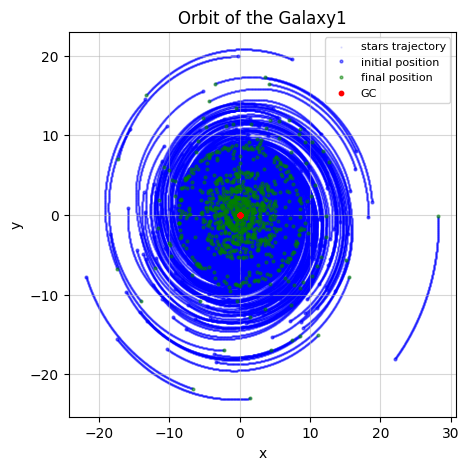

In [12]:
plt.figure(figsize=(5,5))
plt.scatter(Galaxy1_orbit[:,1:,0], Galaxy1_orbit[:,1:,1], s=0.05, color='b', label='stars trajectory', alpha=0.1)
plt.plot(Galaxy1_orbit[0,1:,0], Galaxy1_orbit[0,1:,1], 'o', markersize=0.5, c='b', label='initial position', alpha=0.5)
plt.plot(Galaxy1_orbit[-1,1:,0], Galaxy1_orbit[-1,1:,1], 'o', markersize=0.5, c='g', label='final position', alpha=0.5)
plt.scatter(Galaxy1_orbit[:,0,0], Galaxy1_orbit[:,0,1], s=10, color='r', label='GC', zorder=10)
plt.xlabel('X [Nbody]')
plt.ylabel('Y [Nbody]')
plt.title('Orbit of Galaxy1')
plt.legend(loc='upper right', fontsize=8)
plt.grid(True, alpha=0.5)
plt.show()

We check the total energy error of our simulation. We define a general function we can use for all the simulations. 

In [13]:
def total_energy_error(Etot, initial_t, tsimulation, h):
    energy_error = np.zeros(len(Etot))

    for i in range(len(Etot)):
        energy_error[i] = np.abs((Etot[i] - Etot[0])/Etot[0])

    time = np.arange(0, tsimulation, h)

    return energy_error, time

'\ndef total_energy_error(Etot, initial_t, tsimulation, h):\n    energy_error = np.zeros(len(Etot))\n\n    for i in range(len(Etot)):\n        energy_error[i] = np.abs((Etot[i] - Etot[0])/Etot[0])\n\n    time = np.arange(0, tsimulation, h)\n\n    return energy_error, time\n'

In [14]:
# calculate the error of the total energy for Galaxy1
energy_error, time = total_energy_error(Etot=Galaxy1_Etot, initial_t=t0, tsimulation=tsimulation, h=h)

# plot the error of the total energy for Galaxy1
plt.figure(figsize=(5,5))
plt.plot(time, energy_error, label='Galaxy1')
plt.xlabel('time')
plt.ylabel('energy error')
plt.title('Total energy error for the Galaxy1')
plt.legend()
plt.show()


"\n# calculate the error of the total energy for Galaxy1\n\nenergy_error, time = total_energy_error(Etot=Galaxy1_Etot, initial_t=t0, tsimulation=tsimulation, h=h)\n\n\n# plot the error of the total energy for Galaxy1\nplt.figure(figsize=(5,5))\nplt.plot(time, energy_error, label='Galaxy1')\nplt.xlabel('time')\nplt.ylabel('energy error')\nplt.title('Total energy error for the Galaxy1')\nplt.legend()\nplt.show()\n"

<div class='alert alert-block alert-warning'>
mi pare tanto grande l'errore o sbaglio? penso sia dovuto al fatto degli ordini di grandezza che diceva mattia but not sure
</div>

### Stability of the rotation curve

In [16]:
print(Galaxy1_Rcyl.shape)

(1002, 1000)


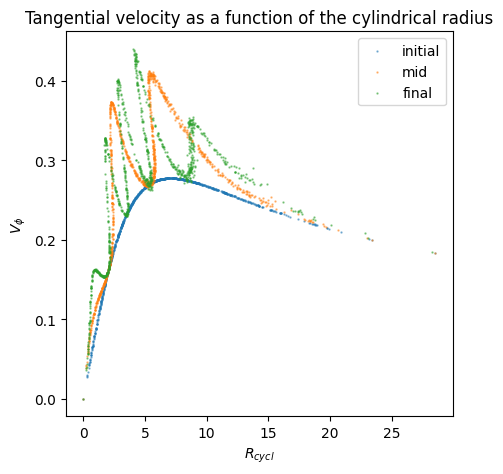

In [17]:
plt.figure(figsize=(5, 5))
n = Galaxy1_Rcyl.shape[0]
snapshots = np.arange(0, n, n//3)
title = ['initial', 'mid', 'final']
for i in range (len(snapshots)):
    plt.scatter(Galaxy1_Rcyl[snapshots[i],:], Galaxy1_Vphi[snapshots[i],:], s=0.5, label=title[i], alpha=0.5)
    
plt.xlabel('$R_{cycl}$')
plt.ylabel('$V_{\phi}$')
plt.title('Tangential velocity as a function of the cylindrical radius')
plt.legend(loc='best')
plt.show()  

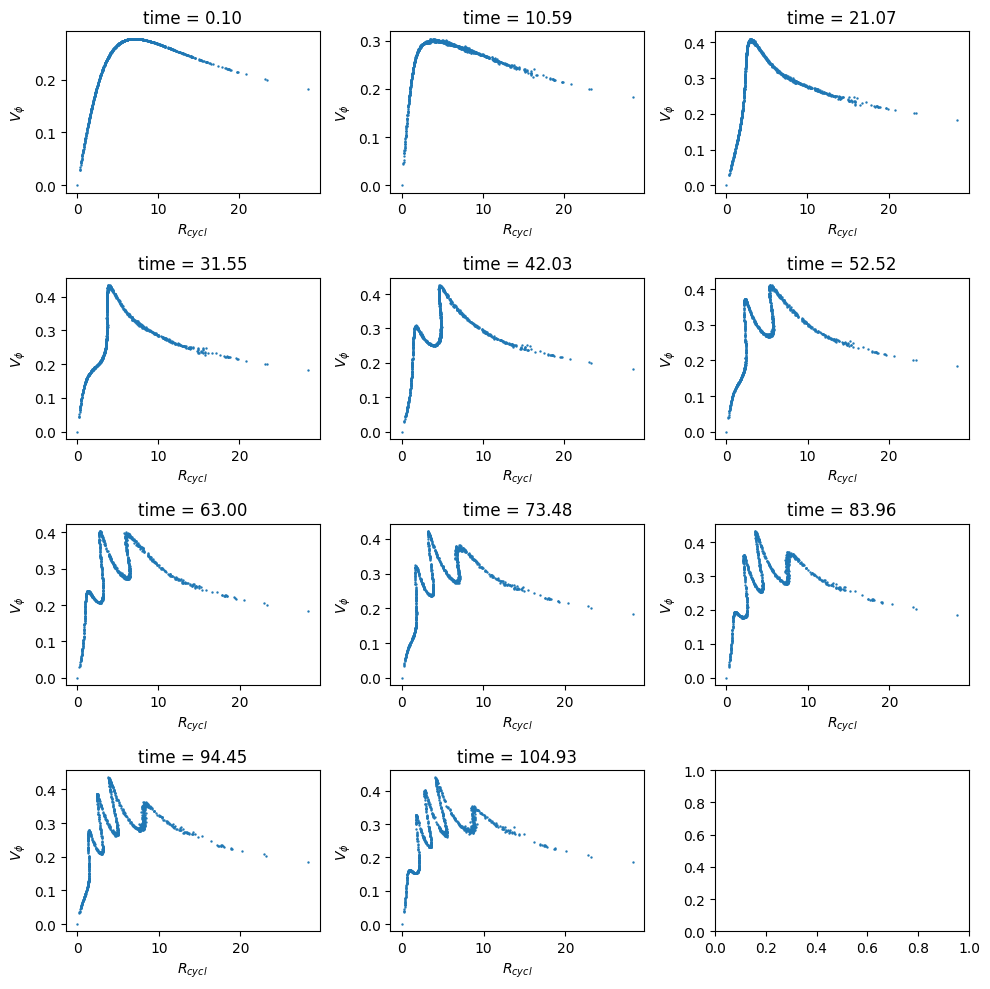

In [18]:
fig, axs = plt.subplots(4, 3, figsize=(10,10))

i_plot = 0
for i in range(0, len(Galaxy1_time), int(len(Galaxy1_time)/10)):
    ax = axs.flatten()[i_plot]
    time_prov = (i*h)/tsimulation
    ax.scatter(Galaxy1_Rcyl[i,:], Galaxy1_Vphi[i,:], s=0.5)

    ax.set_xlabel('$R_{cycl}$')
    ax.set_ylabel('$V_{\phi}$')
    ax.set_title(f'time = {Galaxy1_time[i]:.2f}')
    
    i_plot += 1

plt.tight_layout()
plt.show()

<div class='alert alert-block alert-warning'>
boh qua non capisco sempre solito problema io ci rinuncio
</div>

In [19]:
'''
# intial surface density
mid, H, area = surface_density(Rcyl)

# final surface density
mid_end, H_end, area_end = surface_density(Rcyl_end)

# snapshot of the surface density
mid_mid, H_mid, area_mid = surface_density(Rcyl_mid)
'''

'\n# intial surface density\nmid, H, area = surface_density(Rcyl)\n\n# final surface density\nmid_end, H_end, area_end = surface_density(Rcyl_end)\n\n# snapshot of the surface density\nmid_mid, H_mid, area_mid = surface_density(Rcyl_mid)\n'

In [20]:
'''
plt.figure(figsize=(5,5))
plt.plot(mid, H / area, c='b', label='initial')
plt.plot(mid_mid, H_mid / area_mid, c='g', label='mid')
plt.plot(mid_end, H_end / area_end, c='r', label='final')
plt.yscale('log')
plt.xlabel("Rcyl [Nbody]")  
plt.ylabel("Surface Number Density [Nbody]")
plt.title("Surface Density Profile")
plt.legend()
plt.show()
'''

'\nplt.figure(figsize=(5,5))\nplt.plot(mid, H / area, c=\'b\', label=\'initial\')\nplt.plot(mid_mid, H_mid / area_mid, c=\'g\', label=\'mid\')\nplt.plot(mid_end, H_end / area_end, c=\'r\', label=\'final\')\nplt.yscale(\'log\')\nplt.xlabel("Rcyl [Nbody]")  \nplt.ylabel("Surface Number Density [Nbody]")\nplt.title("Surface Density Profile")\nplt.legend()\nplt.show()\n'

## Galaxy 2

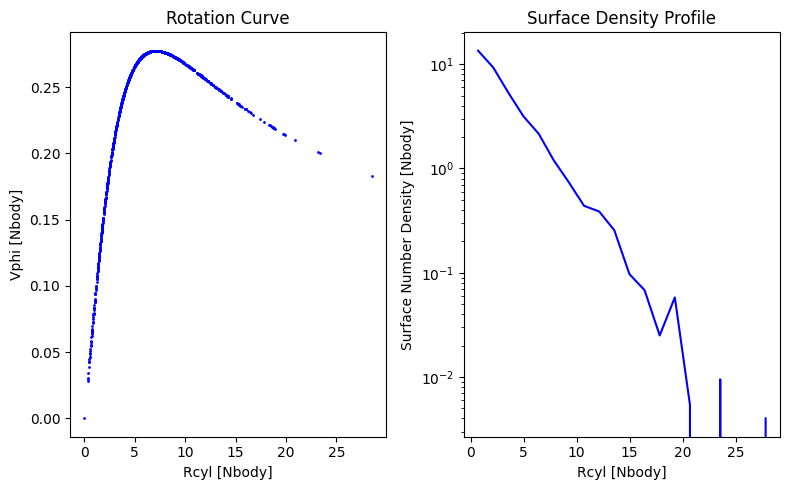

In [21]:
# compute rotation curve and surface density
Rcyl2, _, vel_phi2 = rotation_curve_rescaled(Galaxy2)
mid2, H2, area2 = surface_density(Rcyl2)

# rotation curve plot
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.plot(Rcyl2, vel_phi2, 'o', markersize=1, c='b')
plt.xlabel("Rcyl [Nbody]")
plt.ylabel("Vphi [Nbody]")
plt.title("Rotation Curve")

# surface density plot
plt.subplot(1, 2, 2)
plt.yscale('log')
plt.plot(mid2, H2 / area2, c='b')
plt.xlabel("Rcyl [Nbody]")
plt.ylabel("Surface Number Density [Nbody]")
plt.title("Surface Density Profile")

plt.tight_layout()
plt.show()  


In [22]:
# compute the orbital period with T = 2*pi*sqrt(a^3/GM)

G = 1.                                                                   # gravitational constant in n-body units
plummer_scale_lenght = 5.                                                # scale lenght of the plummer sphere (softening)

central_mass2 = Galaxy1.mass[0]                                           # central mass of the galaxy
radius = np.sqrt(np.sum((Galaxy2.pos-Galaxy2.pos[0])**2., axis=1))  # radius array

T = 2 * np.pi * np.sqrt(radius**3 / (G * central_mass))        # period of the galaxy using radius array  
T = np.mean(T)                                                           # mean period of the galaxy

print(f'Period of the galaxy (approximately): {T}')

# define the time of simulation and the number of steps

t0 = 0.                         # initial time
tsimulation = 1*T               # time of simulation (one period)
N = int(1e3)                    # number of steps
h = (tsimulation - t0)/N        # time steps

Period of the galaxy (approximately): 104.8239304318399


In [23]:
Galaxy2_test = Galaxy2.copy()

Galaxy2_orbit, Galaxy2_stars_vel, Galaxy2_Etot, Galaxy2_time, Galaxy2_Rcyl, Galaxy2_Vphi = integration_leapfrog(galaxy=Galaxy2_test, h=h, 
                                                                                            tsimulation=tsimulation, t=t0, soft=plummer_scale_lenght)

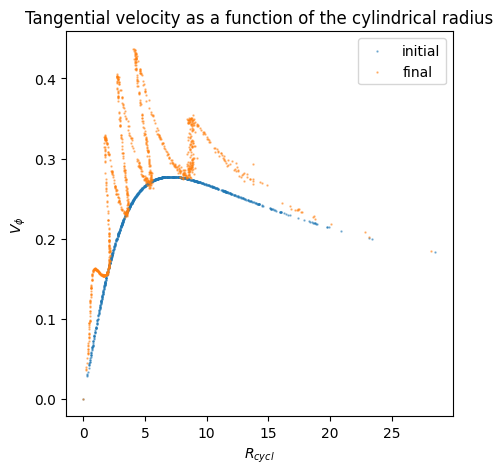

In [24]:
plt.figure(figsize=(5, 5))
n = Galaxy2_Rcyl.shape[0]
snapshots = np.arange(0, n, n//3)
title = ['initial', 'mid', 'final']
for i in range (len(snapshots)):
    plt.scatter(Galaxy2_Rcyl[snapshots[i],:], Galaxy2_Vphi[snapshots[i],:], s=0.5, label=title[i], alpha=0.5)
    
plt.xlabel('$R_{cycl}$')
plt.ylabel('$V_{\phi}$')
plt.title('Tangential velocity as a function of the cylindrical radius')
plt.legend(loc='best')
plt.show()  

### Galaxy encounter

We run a galaxy encounter and then we show how the velocity curve and the disc surface profile evolve with time. 
Make a single class with both galaxies. 

In [26]:
# Combine Galaxy1 and Galaxy2 into a single Particles class
combined_pos = np.concatenate((Galaxy1.pos, Galaxy2.pos))
combined_vel = np.concatenate((Galaxy1.vel, Galaxy2.vel))
combined_mass = np.concatenate((Galaxy1.mass, Galaxy2.mass))

Combined_Galaxies = Particles(combined_pos, combined_vel, combined_mass)

print(Combined_Galaxies.pos.shape)
print(Combined_Galaxies.ID.shape)
print(Combined_Galaxies.pos[0:5], Combined_Galaxies.pos[1000:1005, :])
print(Combined_Galaxies.ID[0:5], Combined_Galaxies.ID[1000:1005])

(2000, 3)
(2000,)
[[  0.           0.           0.        ]
 [ -3.41958304  -1.90178796   0.        ]
 [-14.04683878  -2.40354145   0.        ]
 [ -4.61800261   6.26982091   0.        ]
 [ -6.04551619   0.25797427   0.        ]] [[40.         20.          0.        ]
 [36.58041696 18.09821204  0.        ]
 [25.95316122 17.59645855  0.        ]
 [35.38199739 26.26982091  0.        ]
 [33.95448381 20.25797427  0.        ]]
[0 1 2 3 4] [1000 1001 1002 1003 1004]


In [27]:
# just keep the same tsimulation and N as before
G = 1.                                                                   # gravitational constant in n-body units
T_sim = 210
plummer_scale_lenght = 5.                                                # scale lenght of the plummer sphere (softening)
t0 = 0.
tsimulation = T_sim
N = int(1e3)
h = (tsimulation - t0)/N

Combined_Galaxies_test = Combined_Galaxies.copy()

Combined_Galaxies_orbit, Combined_Galaxies_stars_vel, Combined_Galaxies_Etot, Combined_Galaxies_time, Combined_Galaxies_timestep, Combined_Galaxies_Rcyl, Combined_Galaxies_Vphi = integration_leapfrog(galaxy=Combined_Galaxies_test, h=h, 
                                                                                                                                                                                                        tsimulation=tsimulation, t=t0, soft=plummer_scale_lenght)

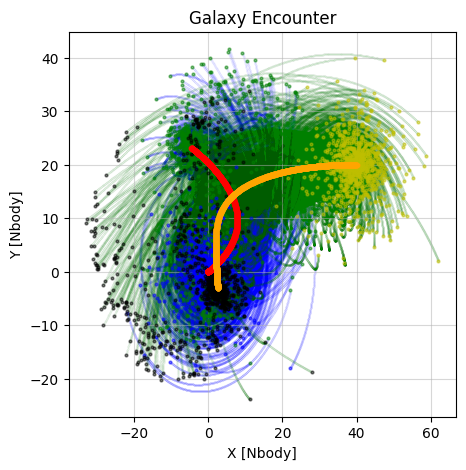

In [28]:
plt.figure(figsize=(5,5))
plt.scatter(Combined_Galaxies_orbit[:,1:1000,0], Combined_Galaxies_orbit[:,1:1000,1], s=0.05, color='b', label='stars trajectory', alpha=0.1)
plt.scatter(Combined_Galaxies_orbit[:,1001:,0], Combined_Galaxies_orbit[:,1001:,1], s=0.05, color='green', label='stars trajectory', alpha=0.1)

plt.plot(Combined_Galaxies_orbit[0,1:1000,0], Combined_Galaxies_orbit[0,1:1000,1], 'o', markersize=2, c='b', label='initial position of G1', alpha=0.5)
plt.plot(Combined_Galaxies_orbit[-1,1:1000,0], Combined_Galaxies_orbit[-1,1:1000,1], 'o', markersize=2, c='g', label='final position of G1', alpha=0.5)

plt.plot(Combined_Galaxies_orbit[0,1001:,0], Combined_Galaxies_orbit[0,1001:,1], 'o', markersize=2, c='y', label='initial position of G2', alpha=0.5)
plt.plot(Combined_Galaxies_orbit[-1,1001:,0], Combined_Galaxies_orbit[-1,1001:,1], 'o', markersize=2, c='k', label='final position of G2', alpha=0.5)

plt.scatter(Combined_Galaxies_orbit[:,0,0], Combined_Galaxies_orbit[:,0,1], s=10, color='r', label='GC 1', zorder=10)
plt.scatter(Combined_Galaxies_orbit[:,1000,0], Combined_Galaxies_orbit[:,1000,1], s=10, color='orange', label='GC 1', zorder=10)

plt.xlabel('X [Nbody]')
plt.ylabel('Y [Nbody]')
plt.title('Galaxy Encounter')
#plt.legend(loc='upper right', fontsize=8)
plt.grid(True, alpha=0.5)
plt.show()
